In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [2]:
def make_mask(sub_df, pvals, m):

    """
    This function calculates summary statistics (mean and 95% confidence intervals) for each region/feature 
    across multiple sub-samples. It then generates a mask based on whether the median p-value for each 
    region is below a specified threshold (m/2). The function returns this mask along with the summary statistics 
    in a DataFrame.
    
    Parameters:
    sub_df (pd.DataFrame): DataFrame containing coefficients from multiple sub-samples for each region/feature.
    pvals (pd.DataFrame): DataFrame of p-values corresponding to the sub-samples.
    
    Returns:
    mask (pd.Series): Boolean mask indicating whether the median p-value for each region/feature is below the threshold.
    dff (pd.DataFrame): DataFrame containing the calculated mean, 5th, and 95th percentiles for each region/feature.
    """
    
    
    # Create an empty DataFrame to store the mean and confidence intervals
    dff = pd.DataFrame(columns=['mean','5th','95th'])

    # Loop through each column (subregion)
    for col in sub_df.columns:
        # Calculate the mean coefficient for the column (region/feature) across all sub-samples
        mu = sub_df[col].mean()

        # Calculate the 5th and 95th percentiles (confidence intervals)
        # lower bound (lb), upper bound (lb)
        lb, up = np.percentile(sub_df[col], [5,95])

        # Save stats
        values = np.array([mu,lb,up]).reshape(1,3)
        tmp = pd.DataFrame(values,columns=['mean','5th','95th'],index=[col])

        # Append stats for that column
        dff = pd.concat([dff,tmp])

    # Store subregion labels    
    dff['Subregions'] = dff.index

    # Create a mask DataFrame based on the median of p-values across sub-samples
    # Mask is True if the median p-value for a region is less than m/2
    mask_df = pd.DataFrame(pvals.T.median()<(m/2),columns=['mask'])

    # Apply mask
    dff = dff.merge(mask_df, left_index=True, right_index=True)
    mask = dff['mask']

    # Print regions that passed the filter
    print(dff.iloc[np.where(mask==True)].index)
    
    return mask, dff

In [3]:
def plot_axs(df, mask, ax, all_inds, combined_mask, sex_inds):
    """
    Plot coefficient point estimates with error bars and color-coded markers
    for either males or females within a brain network.

    Parameters:
    - df: DataFrame with columns ["mean", "5th", "95th", "Subregions"] indexed by region
    - mask: boolean Series for selected rows in df (sex-specific)
    - ax: matplotlib axis to plot on
    - all_inds: ordered list of region labels to display on y-axis
    - combined_mask: combined boolean mask across sexes
    - sex_inds: subset of all_inds corresponding to current sex (used to control plotting)

    Returns:
    - g: seaborn pointplot object
    - x_masked: array of mean values for plotted regions
    """

    df = df.copy().sort_index()

    # Plot invisible white points for layout
    g = sns.pointplot(
        data=df.loc[all_inds],
        x="mean", y="Subregions",
        capsize=0.1, linestyle='none', color='white', ax=ax
    )

    # Subset df to the regions to display (all_inds)
    df_disp = df.loc[all_inds]

    # Create boolean mask aligned with all_inds to indicate which are from this sex
    include = [region in sex_inds for region in all_inds]

    # Extract mean and CI bounds from df_disp
    x = df_disp["mean"].values
    lb = x - df_disp["5th"].values
    ub = df_disp["95th"].values - x
    err = np.vstack([lb, ub])

    # Y-axis positions (for all_inds)
    y = np.arange(len(all_inds))

    # Apply include mask
    x_masked = x[include]
    y_masked = y[include]
    err_masked = err[:, include]

    # Colors based on sign of effect
    colors = ['blue' if val < 0 else 'red' for val in x_masked]

    # Plot error bars
    ax.errorbar(x_masked, y_masked,
                xerr=err_masked, fmt='none',
                ecolor=colors, elinewidth=0.5, zorder=2)

    # Plot points (different marker for pos/neg)
    ax.scatter(x_masked[x_masked < 0], y_masked[x_masked < 0],
               color='blue', marker='s', zorder=3)
    ax.scatter(x_masked[x_masked > 0], y_masked[x_masked > 0],
               color='red', marker='o', zorder=3)

    return g, x_masked


# Hippocampus

## Prevent-AD

In [4]:
date = '25.05.13'
path = f'{date}/brain_imaging/diagnostic_test'

In [5]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

Index(['CA1-body_left', 'CA1-head_left', 'molecular_layer_HP-head_left',
       'CA4-head_left', 'subiculum-body_right', 'CA3-body_right',
       'fimbria_right'],
      dtype='object')
Index(['presubiculum-head_left', 'presubiculum-body_left',
       'parasubiculum_left', 'HATA_left', 'subiculum-body_right',
       'CA3-body_right'],
      dtype='object')


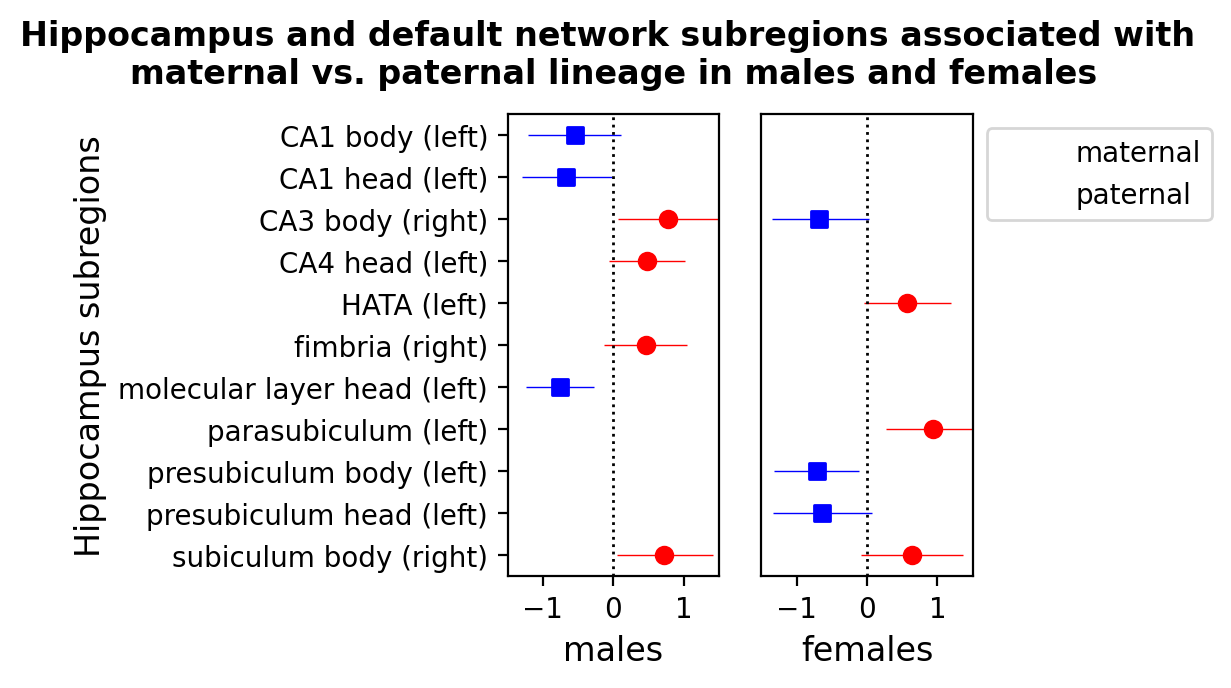

In [6]:
# --------------------------------------------
# Plot hippocampus subregion associations with maternal vs. paternal lineage
# --------------------------------------------

# Load permutation p-values
all_pvals_f = pd.read_csv(f'{path}/prevent_ad_hc_all_pvals_f_1000_2025.csv', index_col=0)
all_pvals_m = pd.read_csv(f'{path}/prevent_ad_hc_all_pvals_m_1000_2025.csv', index_col=0)

# Threshold for significance masking
for p_thresh in [0.20]:

    # Set up figure
    fig = plt.figure(figsize=(3, 3), dpi=200)
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    
    # -------- MALES --------
    hc_m = pd.read_csv(f'{path}/all_coefs_males_prevent_AD_hc_2025.csv')
    mask_m, df_hc_m = make_mask(hc_m, all_pvals_m, p_thresh)
    inds_m = df_hc_m[mask_m].sort_index().index

    # -------- FEMALES --------
    hc_f = pd.read_csv(f'{path}/all_coefs_females_prevent_AD_hc_2025.csv')
    mask_f, df_hc_f = make_mask(hc_f, all_pvals_f, p_thresh)
    inds_f = df_hc_f[mask_f].sort_index().index

    # Combine indices across sexes
    combined_inds = sorted(set(inds_f).union(inds_m))
    mask_mf = mask_m | mask_f  # Union mask across sexes

    # Plot males
    _, _ = plot_axs(df_hc_m, mask_m, ax1, combined_inds, mask_mf, inds_m)
    ax1.set_xlabel('males', fontsize=12)
    ax1.set_ylabel('Hippocampus subregions', fontsize=12)
    ax1.set_title(
        'Hippocampus and default network subregions associated with \n'
        'maternal vs. paternal lineage in males and females',
        fontsize=12,
        fontweight='bold',
        x=0.5,
        y=1.03
    )

    # Plot females
    _, _ = plot_axs(df_hc_f, mask_f, ax2, combined_inds, mask_mf, inds_f)
    ax2.set_xlabel('females', fontsize=12)
    ax2.set_yticks([])  # Remove y-axis labels from right plot
    ax2.set_ylabel("")  # Explicitly clear label

    # Add legend
    plt.legend(['maternal', 'paternal'], bbox_to_anchor=(1, 1))

    # Clean up y-axis tick labels for hippocampus subregions
    labels = [label.get_text() for label in ax1.get_yticklabels()]
    cleaned_labels = [
        label.replace('_HP-', ' ')
             .replace('_', ' ')
             .replace('-', ' ')
             .replace('right', '(right)')
             .replace('left', '(left)')
        for label in labels
    ]
    ax1.set_yticks(range(len(cleaned_labels)))
    ax1.set_yticklabels(cleaned_labels)
    ax1.set_xlim(-1.5, 1.5)
    ax2.set_xlim(-1.5, 1.5)
    ax1.axvline(x=0, color='black', linestyle=':', linewidth=1)
    ax2.axvline(x=0, color='black', linestyle=':', linewidth=1)


    # Save and show plot
    #plt.savefig(f'{date}/permutation_masked_hc_mat_pat_males_females_prevent_ad_{p_thresh}.png', dpi=200, bbox_inches='tight')
    plt.show()
    plt.close()


# Default Network

## Prevent-AD

In [7]:
col_DN = pd.read_csv(f'{path}/all_coefs_males_prevent_AD_dn_2025.csv',index_col=0).columns

Index(['LH_Default_Temp_3_volume', 'LH_Default_Par_5_volume',
       'LH_Default_Par_6_volume', 'LH_Default_pCunPCC_9_volume',
       'RH_Default_PFCv_2_volume', 'RH_Default_pCunPCC_6_volume'],
      dtype='object')
Index(['lh_7Networks_LH_Default_Temp_1_volume', 'LH_Default_PFC_15_volume'], dtype='object')


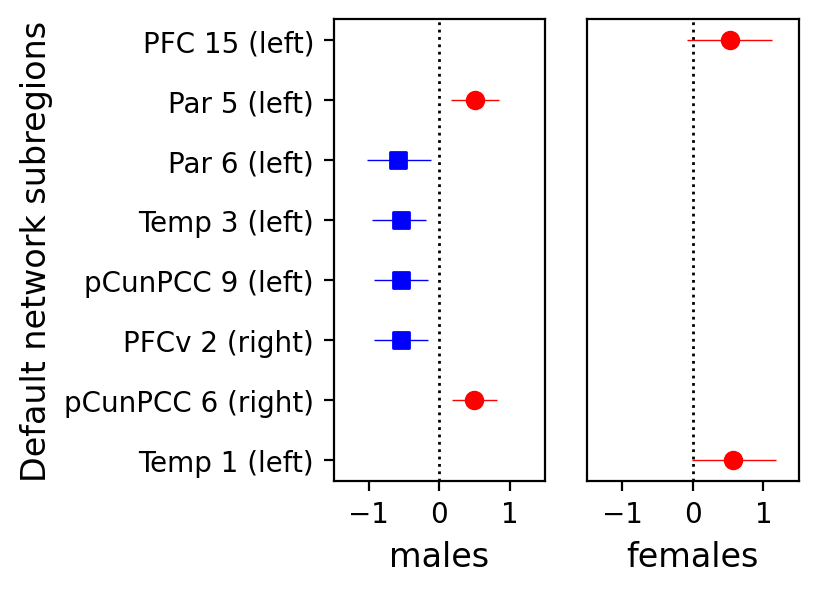

In [8]:
# --------------------------------------------
# Plot default network subregion associations with maternal vs. paternal lineage
# --------------------------------------------

# Load permutation p-values
all_pvals_f = pd.read_csv(f'{path}/prevent_ad_dn_all_pvals_f_1000_2025.csv', index_col=0)
all_pvals_m = pd.read_csv(f'{path}/prevent_ad_dn_all_pvals_m_1000_2025.csv', index_col=0)

# Threshold for significance masking
for p_thresh in [0.20]:

    # Set up figure
    fig = plt.figure(figsize=(3, 3), dpi=200)
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    
    # -------- MALES --------
    dn_m = pd.read_csv(f'{path}/all_coefs_males_prevent_AD_dn_2025.csv')
    mask_m, df_dn_m = make_mask(dn_m, all_pvals_m, p_thresh)
    inds_m = df_dn_m[mask_m].sort_index().index

    # -------- FEMALES --------
    dn_f = pd.read_csv(f'{path}/all_coefs_females_prevent_AD_dn_2025.csv')
    mask_f, df_dn_f = make_mask(dn_f, all_pvals_f, p_thresh)
    inds_f = df_dn_f[mask_f].sort_index().index

    # Combine indices across sexes
    combined_inds = sorted(set(inds_f).union(inds_m))
    mask_mf = mask_m | mask_f  # Union mask

    # Plot males
    plot_axs(df_dn_m, mask_m, ax1, combined_inds, mask_mf, inds_m)
    ax1.set_xlabel('males', fontsize=12)
    ax1.set_ylabel('Default network subregions', fontsize=12)

    # Plot females
    plot_axs(df_dn_f, mask_f, ax2, combined_inds, mask_mf, inds_f)
    ax2.set_xlabel('females', fontsize=12)
    ax2.set_yticks([])
    ax2.set_ylabel('')

    # Clean and relabel y-axis tick labels for default network subregions
    labels = [label.get_text() for label in ax1.get_yticklabels()]
    cleaned_labels = []

    for label in labels:
        label = label.replace('lh_7Networks_LH_Default_Temp_1_volume', 'LH_Default_Temp_1_volume')
        label = label.replace('LH', 'left').replace('RH', 'right')
        parts = label.split('_')[:-1]
        if len(parts) >= 4:
            name = f"{parts[2]}_{parts[3]}_({parts[0]})"
            name = name.replace('_', ' ')
            cleaned_labels.append(name)
        else:
            cleaned_labels.append(label)  # fallback if unexpected format

    ax1.set_yticklabels(cleaned_labels)
    ax1.set_xlim(-1.5, 1.5)
    ax2.set_xlim(-1.5, 1.5)
    ax1.axvline(x=0, color='black', linestyle=':', linewidth=1)
    ax2.axvline(x=0, color='black', linestyle=':', linewidth=1)

    # Save and show plot
    #plt.savefig(f'{date}/permutation_masked_dn_mat_pat_males_females_prevent_ad_{p_thresh}.png', dpi=200, bbox_inches='tight')
    plt.show()
    plt.close()
